# Working with HDF5 and the Keras NN Library for Stock Forecasting
In this notebook we're going to work through wrangling some stock data using pandas and the HDF5 python library h5py. We'll use both matplotlib and an extension of it called Seaborn for visualization and then we'll train a model and predict whether today's closing price will be up or down.  My previous work has generally produced results of approximately 85% accuracy for a 1-day prediction.

First we'll set up some tools for our environment and select the ticker symbol of the stock we want to analyze.

In [1]:
import numpy, pandas                 #  Pandas is great for timeseries wrangling
import pandas_datareader.data as web #  Switch this out for yahoo_finance.Share('ticker') 
from datetime import datetime        #  Easier date usage
import h5py                          #  Binary Data Storage
import matplotlib.pyplot as plt      #  For data visualizations
%matplotlib inline                   
import seaborn as sns
TICKER = 'YUM'

Now we'll look at how the stock has performed and develop some graphical representations using matplotlib and seaborn.

In [2]:
start, end = datetime(2006,1,1), datetime(2016,1,9)  # Setting the date range
data = pandas.DataFrame(web.DataReader( TICKER, 'yahoo', start, end )) #getting the data
del data['Volume']

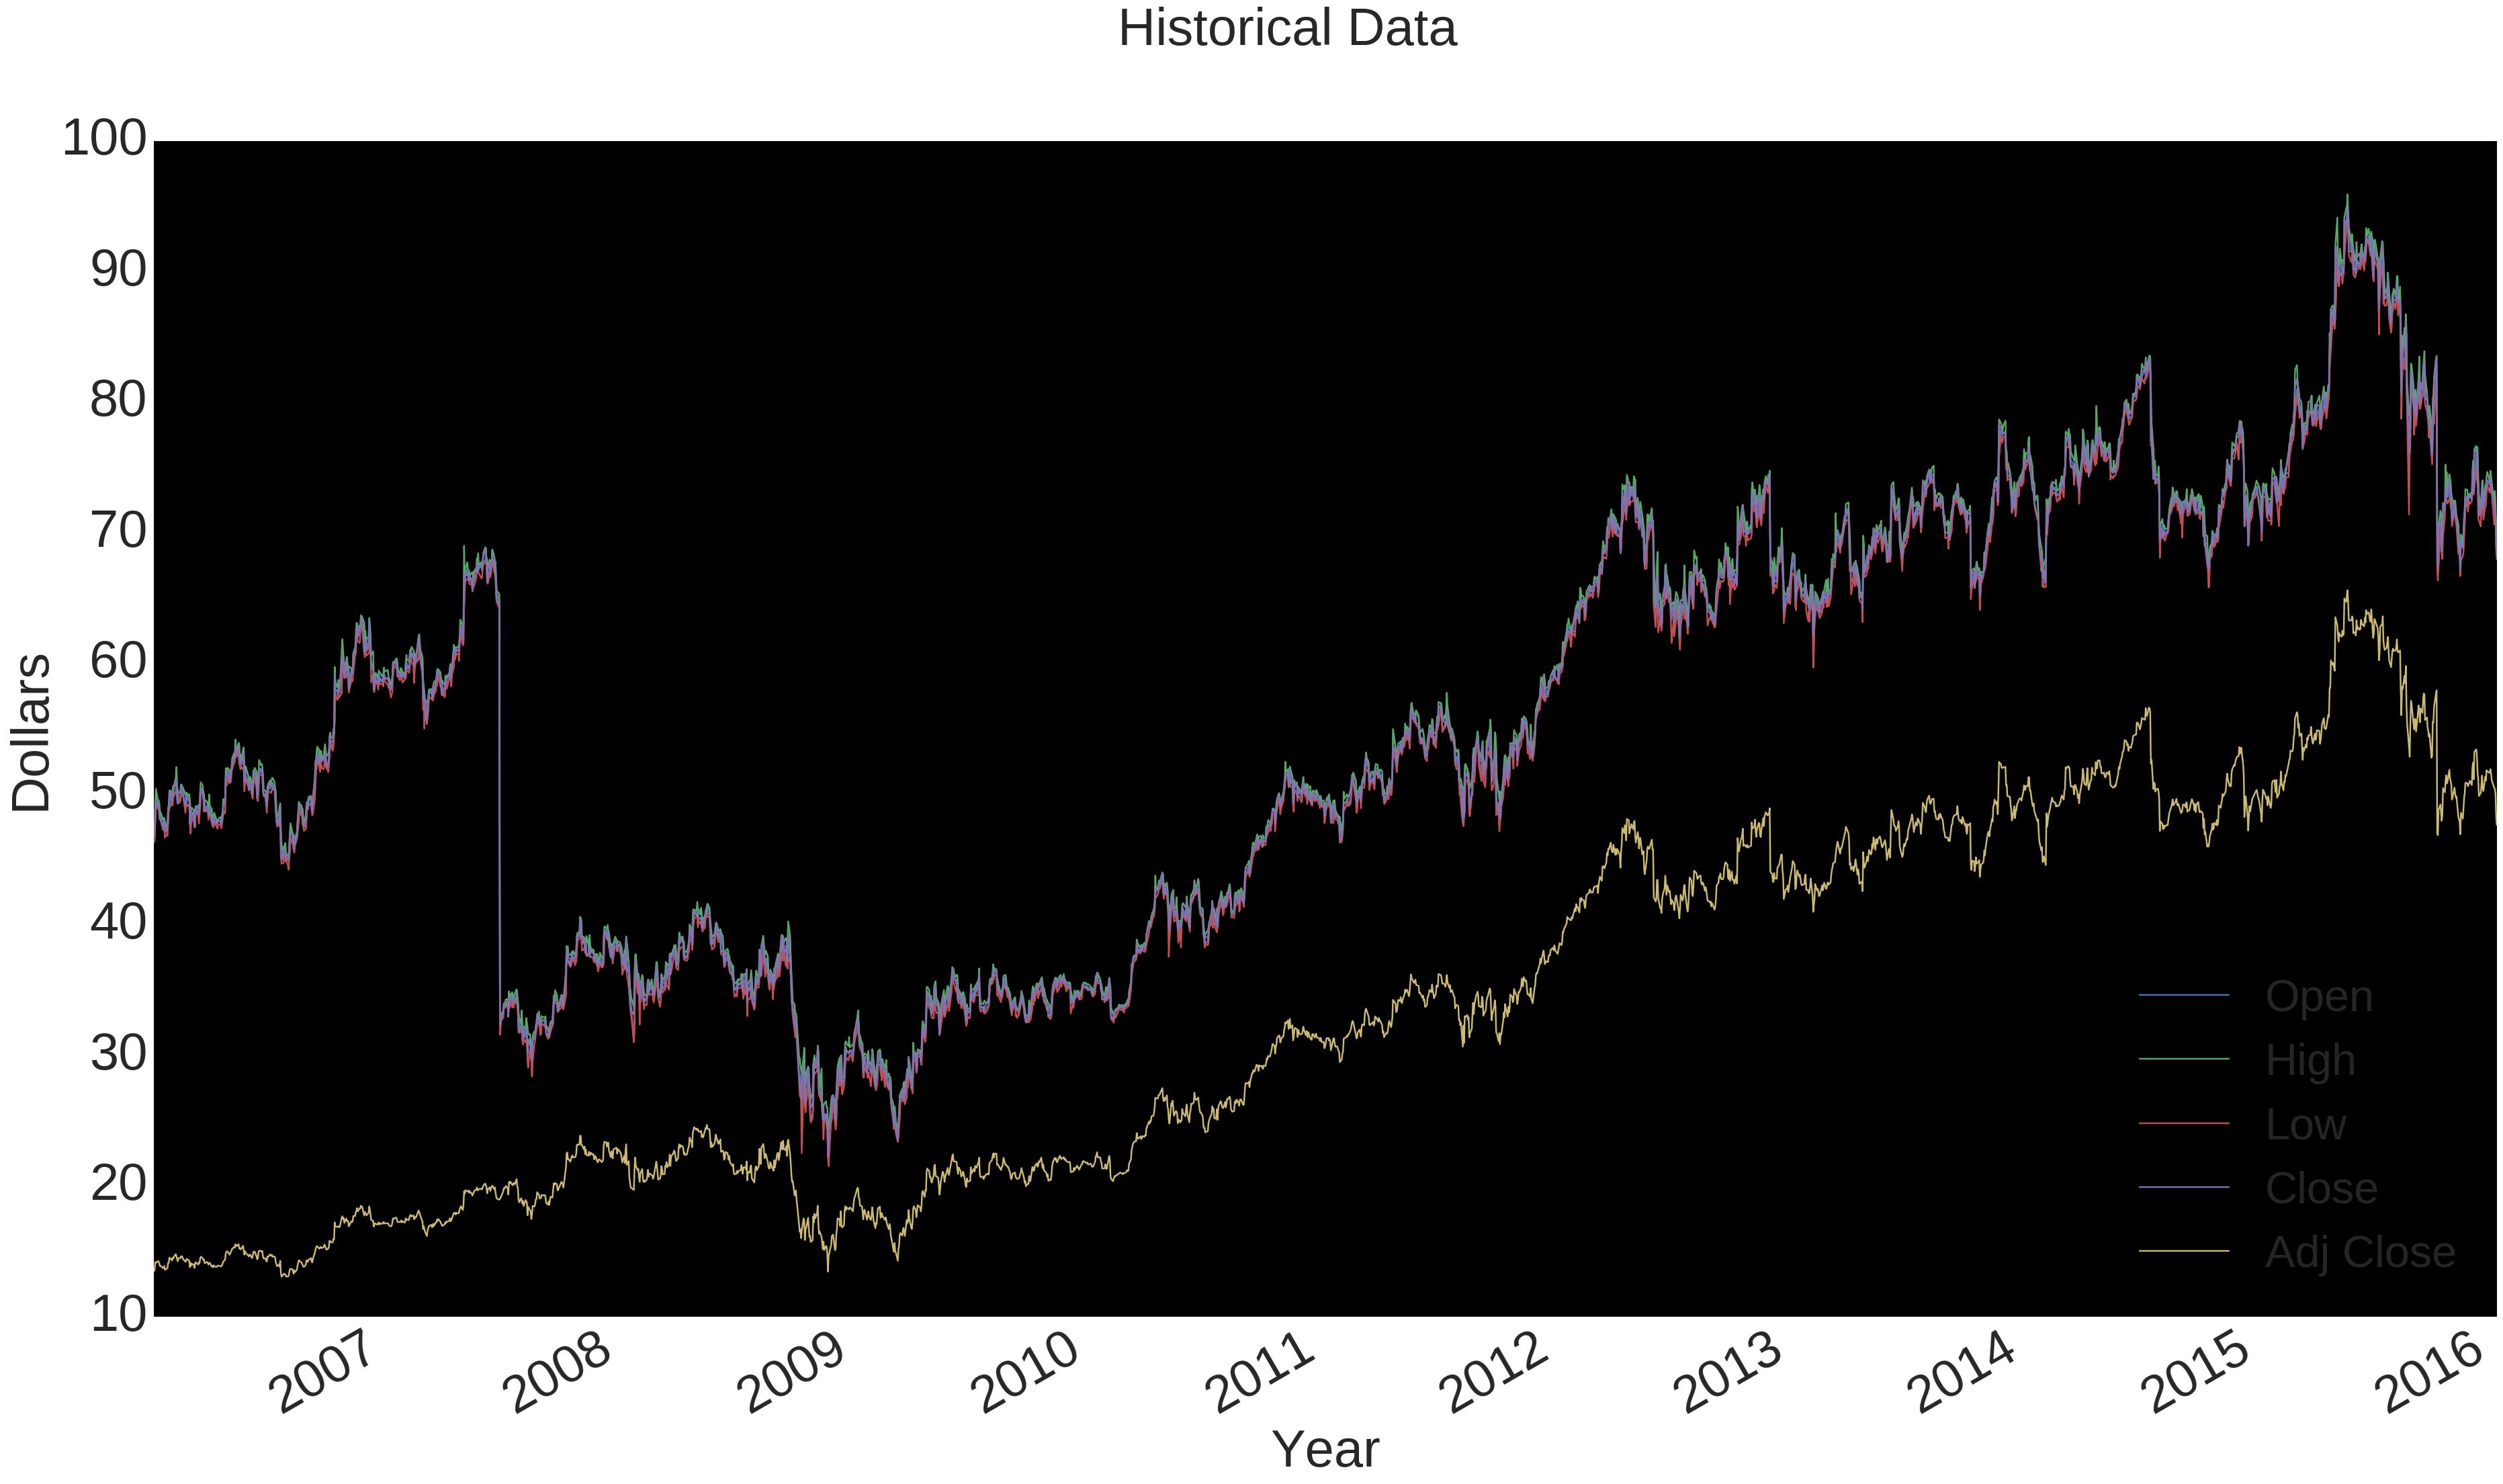

In [3]:
sns.set_style("dark")
plt.rcParams['axes.facecolor'] = 'black';
data.plot(figsize=(45,25));plt.legend(loc='lower right', prop={'size':48});
plt.xlabel('Year', fontsize=56);plt.ylabel('Dollars', fontsize=56);plt.suptitle('Historical Data', fontsize=56);
plt.tick_params(axis='both', which='major', labelsize=56);
plt.rcParams.update({'font.size': 56}); plt.show()  #  Plotting the historical data

Now let's add some data for the percent change, thankfully pandas makes this easy for us.

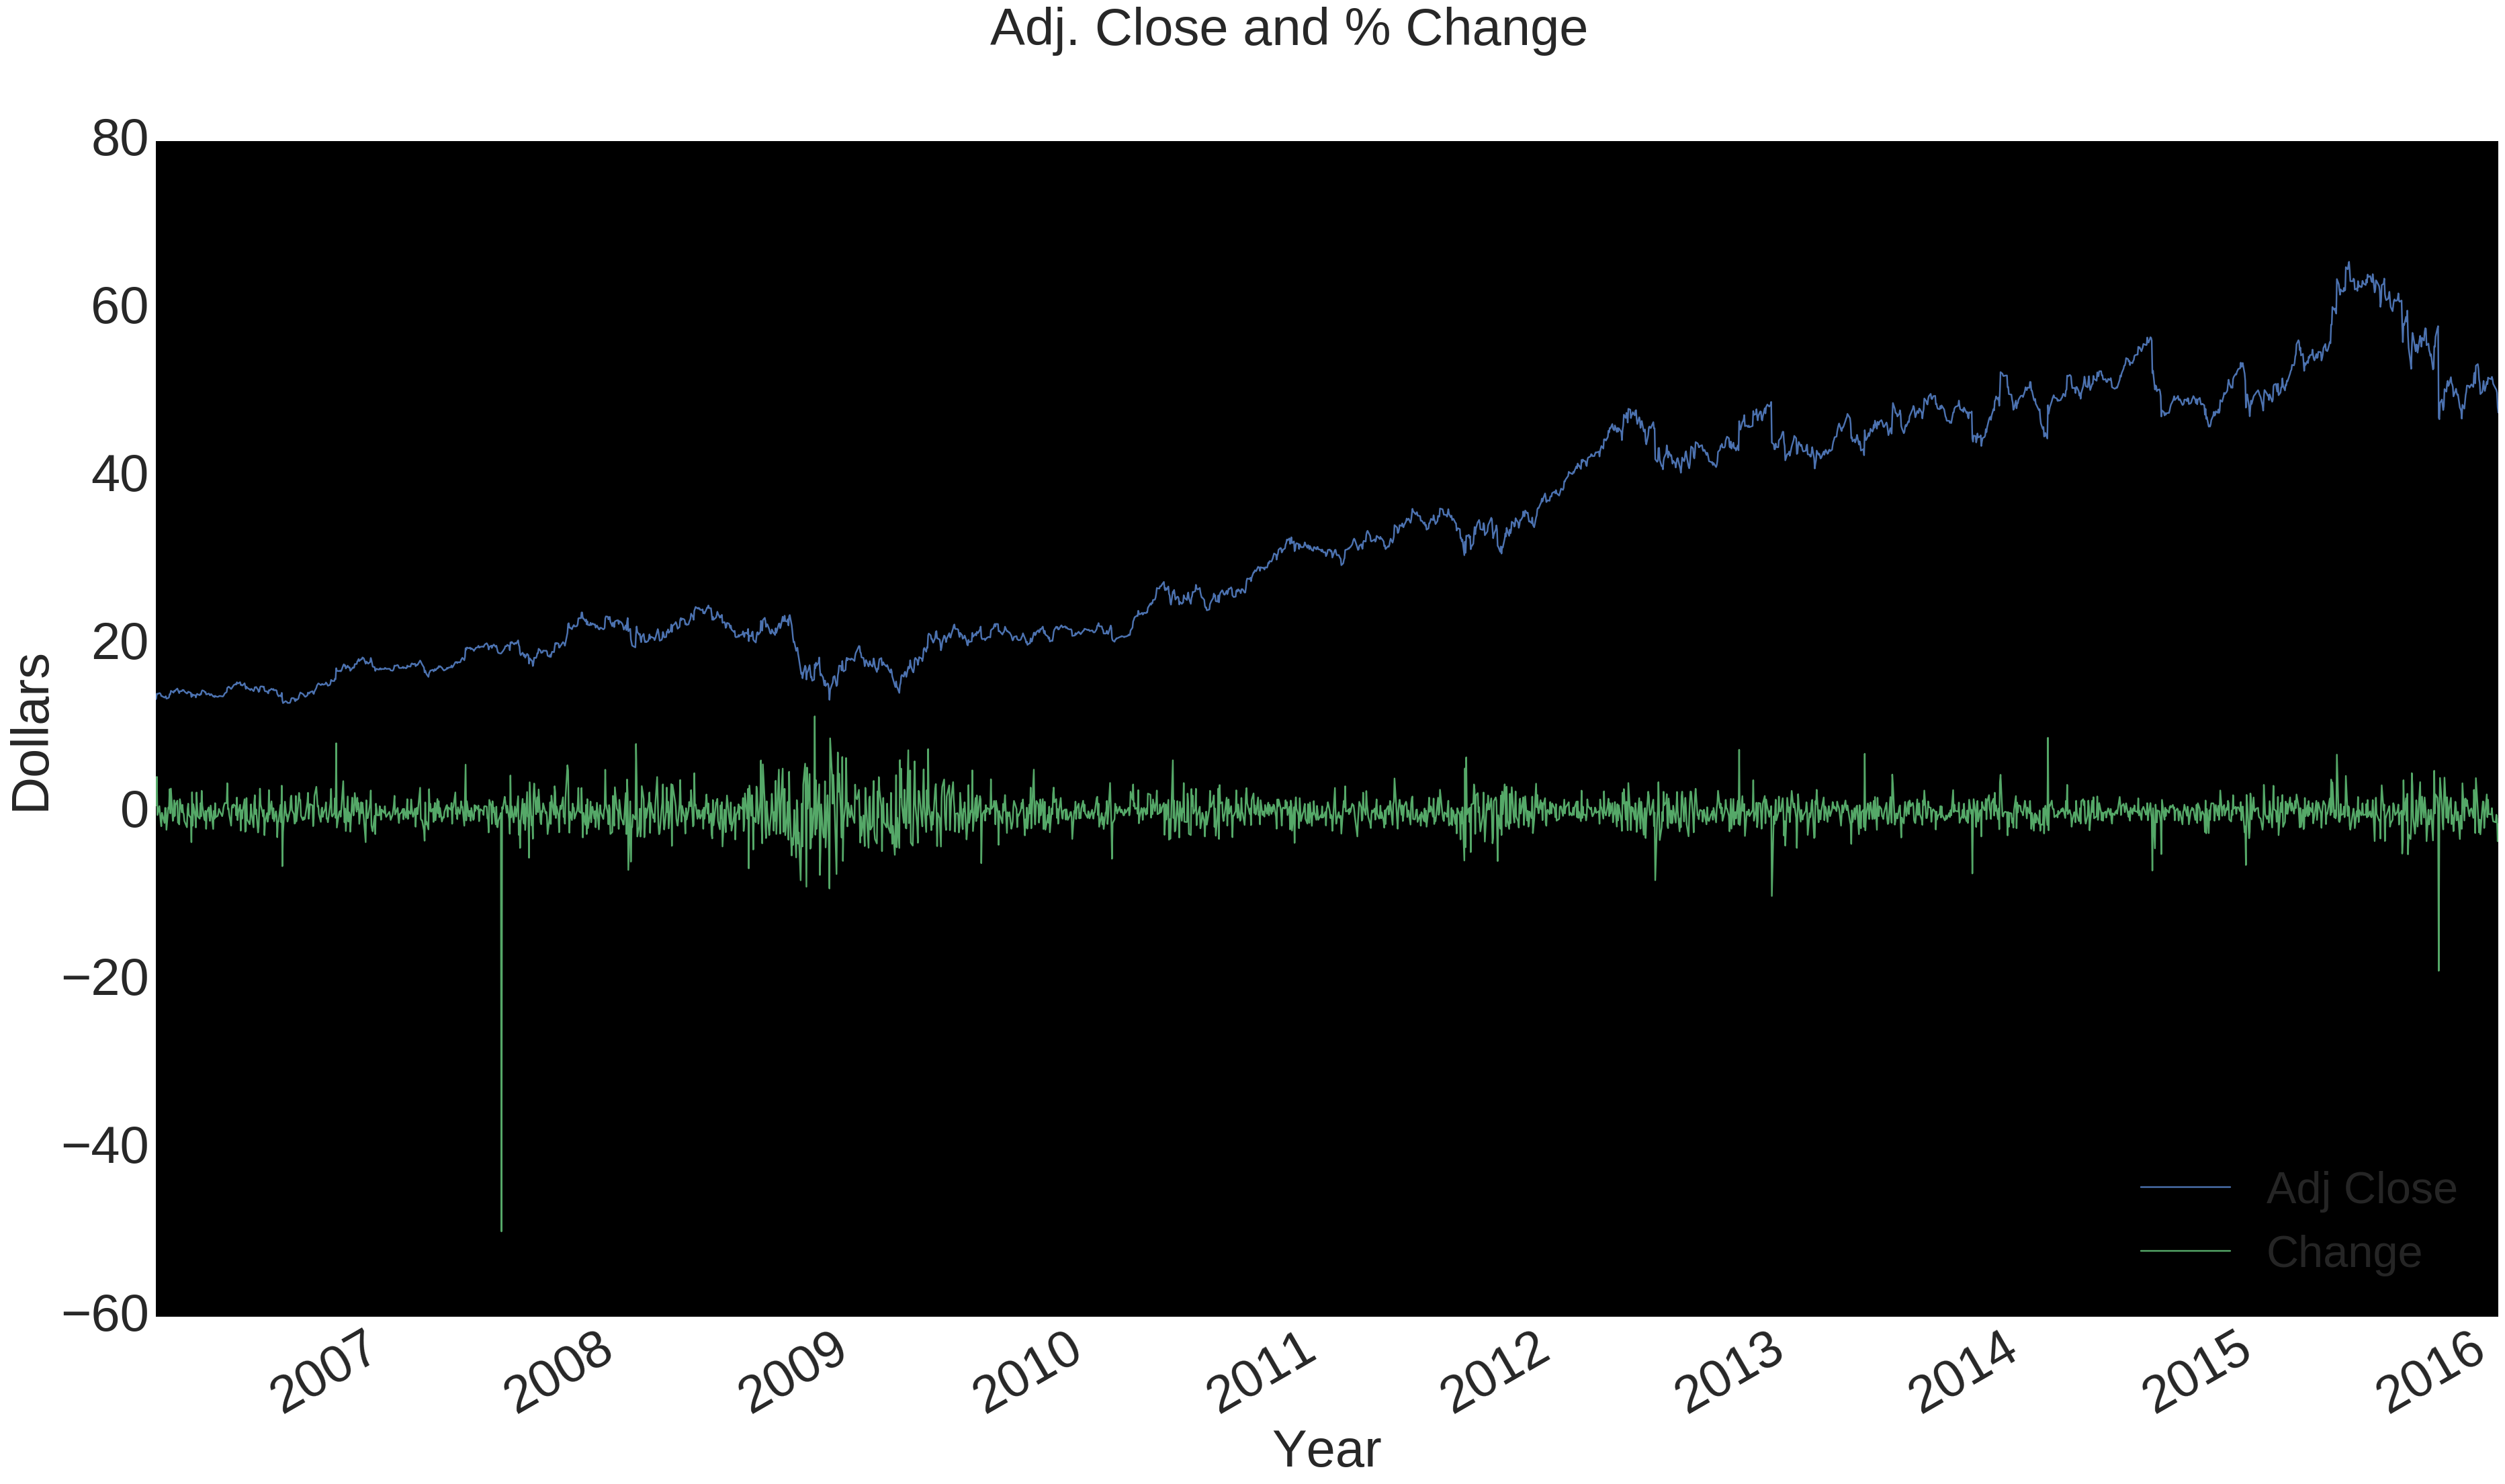

In [4]:
data['Change'] = data.Close.pct_change()*100
data['Adj Close'].plot(figsize=(45,25)); data['Change'].plot(); plt.legend(loc='lower right', prop={'size':48});
plt.xlabel('Year', fontsize=56);plt.ylabel('Dollars', fontsize=56);plt.suptitle('Adj. Close and % Change', fontsize=56);
plt.tick_params(axis='both', which='major', labelsize=56);
plt.rcParams.update({'font.size': 56}); plt.show()

Now that we've explored our data a bit, we can focus on gathering the data in a form for training our model, actually training that model, and storing the data as HDF5 data.

In [5]:
from yahoo_finance import Share
stock = Share(TICKER)
stock_data = pandas.DataFrame(stock.get_historical('2006-1-1','2016-1-1'))
myarr = numpy.array(stock_data['Close'].values, dtype=float)
stock_data.columns.values.tolist()

['Adj_Close', 'Close', 'Date', 'High', 'Low', 'Open', 'Symbol', 'Volume']

In [6]:
data_20day = list()
for i in range(len(myarr)-20):
    data_20day.append(myarr[i:i+20])
arrdat = numpy.array(data_20day)
h5f = h5py.File('yum_data.h5', 'w')
h5f.create_dataset('dataset_1', data=arrdat)
h5f.close()

Now at this point we have saved the data, so we could stop and pick back up here if we wanted by just reading the HDF5 file that we stored.

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
#import h5py
h5f = h5py.File('yum_data.h5','r')
train = h5f['dataset_1'][:]
h5f.close()
np.reshape(train, (-1, 20))
print(train.shape)
target_vals = [1]
for i in range(train.shape[0]-1):
    if train[i,-1] < train[i+1,0]:
        target_vals.append(1)
    else: target_vals.append(0)

Using TensorFlow backend.


(2497, 20)


Now we'll set some of the parameters for training our neural network and then set it to train on our test set.

In [35]:
model=Sequential()
model.add(Dense(32, input_dim = train.shape[1], init='uniform'))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(output_dim=1))
model.add(Activation("sigmoid"))

model.compile(loss='mean_squared_error', optimizer='Adadelta', metrics=['accuracy'])

model.fit(train, target_vals, nb_epoch=300, batch_size=32);

Epoch 1/300
2497/2497 [==============================] - 0s - loss: 0.4151 - acc: 0.5322      

One nice feature is how we can observe the mean squared loss after each epoch.

Now we'll create a test set in a similar way to how we created our training set.

In [36]:
# Now we'll create a set to test on
stock_test = pandas.DataFrame(stock.get_historical('2016-1-1','2017-1-10'))
myarr2 = numpy.array(stock_test['Close'].values, dtype=float)
myarr2.size
test_20day = list()
for i in range(len(myarr2)-20):
    test_20day.append(myarr2[i:i+20])
arrdat2 = numpy.array(test_20day)
h5f = h5py.File('yum_test.h5', 'w')
h5f.create_dataset('testset_1', data=arrdat2)
h5f.close()

In [37]:
#Now we test performance
h5f = h5py.File('yum_test.h5','r')
test = h5f['testset_1'][:]
h5f.close()
np.reshape(test, (-1, 20))
print(test.shape)
real_vals = [1]
for i in range(test.shape[0]-1):
    if test[i,-1] < test[i+1,0]:
        real_vals.append(1)
    else: real_vals.append(0)

(238, 20)


Now we can evaluate our model's performance!

In [38]:
score = model.evaluate(test, real_vals, batch_size=16)

160/238 [===================>..........] - ETA: 0s

This looks promising, but I want to run my own kind of analysis.  I want to round the values to see whether they hit or miss accordingly.

In [39]:
results = model.predict(test)
yay = 0
nay = 0
for i in range(len(results)):
    if round(float(results[i]))==round(float(real_vals[i])):
        yay += 1
    else: nay +=1
print('yay= ', yay, ' ,nay= ', nay, yay/(yay+nay), ' % correct predictions')

yay=  222  ,nay=  16 0.9327731092436975  % correct predictions


So what we wind up hitting is a whopping 93% success rate predicting the performance of the stock for whether it will increase or decrease. Let's predict tomorrow's performance...

In [40]:
today_test = pandas.DataFrame(stock.get_historical('2016-1-1','2017-1-12'))
myarr3 = numpy.array(stock_test['Close'].values, dtype=float)
myarr3.size
today_20day = list()
for i in range(len(myarr3)-20):
    today_20day.append(myarr3[i:i+20])
arrdat3 = numpy.array(today_20day)
np.reshape(arrdat3, (-1, 20))
print(arrdat3.shape)

#today = pandas.DataFrame(stock.get_historical('2016-12-1','2017-1-11'))
#today_val = today['Adj_Close']
#today_test = np.array(today_val[-20:]).transpose()
#np.reshape(today_test, (-1, 20))

(238, 20)


In [41]:
new_predict = model.predict(arrdat3)
print(new_predict[-1])

[ 0.92792928]


So our prediction is that tomorrow the stock will close up, I can't wait to see if it is right! Update, I ran it again for today, yesterday's prediction was correct with the stock being up 17 cents per share. It says it should be up today as well so we'll see what happens!